# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [ ]:
! ls

accars_b.xlsx  sample_data


#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel("accars_b.xlsx")

Nombre de valeurs manquantes par colonne :
wbe                            36699
tsih                           32885
zwbp1                          32640
zwbp2                          32640
cycles                         30553
zhptac                         29817
zlptac                         29805
ztla                           28359
vbvpos                         27236
zt3                            26357
zt25                           26357
zps3                           25835
zvsv                           24228
zphsr                          13497
zphsf                          12060
cas                            11920
zwf36                           7266
zvb2f                           6800
zvb2r                           6690
zvb1r                           6682
zvb1f                           6682
ztoil                           6560
zpoil                           6546
sloatl                          1351
pcn1k                           1351
egthdm                          

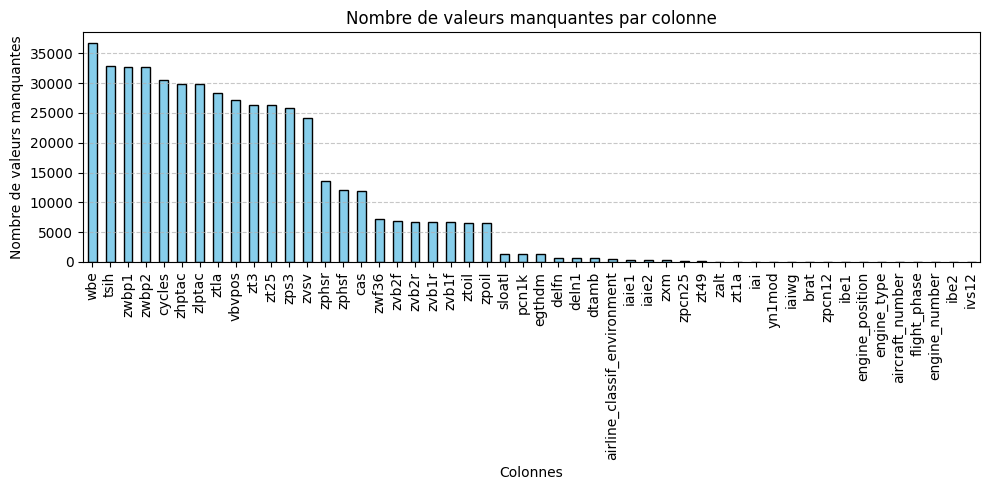

In [ ]:
# Vérification des valeurs manquantes
valeurs_manquantes = df.isna().sum().sort_values(ascending=False)

# Affichage du tableau des valeurs manquantes
print("Nombre de valeurs manquantes par colonne :")
print(valeurs_manquantes)

# Représentation graphique : bar plot
plt.figure(figsize=(10, 5))
valeurs_manquantes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre de valeurs manquantes par colonne")
plt.xlabel("Colonnes")
plt.ylabel("Nombre de valeurs manquantes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Ici les 0 représentent les colonnes qui ne contiennent aucune valeur manquante.
Autrement dit, dans ces colonnes, toutes les observations sont complètes il n’y a aucun NaN (aucune donnée absente).

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [ ]:
# On supprime les lignes où 'cycles' ou 'egthdm' contiennent des valeurs manquantes
df = df.dropna(subset=['cycles', 'egthdm'])

# Vérification du nouveau nombre de lignes
print("Nombre de lignes restantes :", len(df))


Nombre de lignes restantes : 15374


#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [ ]:
# Afficher les différents types de moteurs présents dans la base
types_moteurs = df['engine_type'].unique()
print("Types de moteurs :", types_moteurs)


Types de moteurs : [10  5  7]


#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [ ]:
# Filtrer uniquement les moteurs de type 10
df_type10 = df[df['engine_type'] == 10]

# Nombre d'avions distincts
nb_avions = df_type10['aircraft_number'].nunique()
print("Nombre d'avions distincts :", nb_avions)

# Comptage des lignes par avion
vols_par_avion = df_type10.groupby('aircraft_number').size() / 2  # deux moteurs par avion
print("\nNombre de vols par avion (en moyenne) :")
print(vols_par_avion)


Nombre d'avions distincts : 5

Nombre de vols par avion (en moyenne) :
aircraft_number
11      17.0
14      97.0
190    110.0
191      6.0
192    126.0
dtype: float64


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [ ]:
# Filtrage des données pour l'avion numéro 190
avion_190 = df[df['aircraft_number'] == 190][['engine_number', 'cycles', 'egthdm']]

# Affichage des premières lignes
print(avion_190.head())


       engine_number  cycles   egthdm
11398            179    98.0  52.0118
11399            180    69.0  57.6415
11400            180    75.0  48.7217
11755            179     0.0  37.6572
11756            179     1.0  37.2208


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

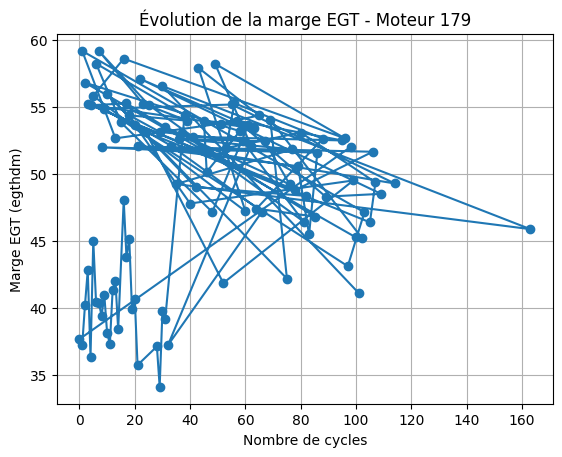

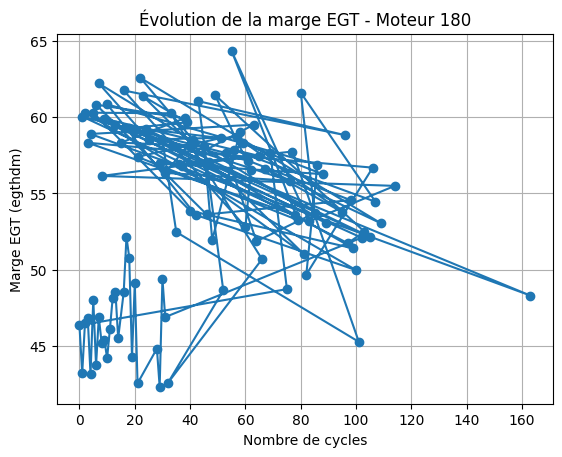

In [ ]:
# On récupère les numéros de moteurs de l’avion 190
moteurs = avion_190['engine_number'].unique()

# Création d’un graphique pour chaque moteur
for moteur in moteurs:
    data_moteur = avion_190[avion_190['engine_number'] == moteur]
    plt.figure()
    plt.plot(data_moteur['cycles'], data_moteur['egthdm'], marker='o')
    plt.title(f"Évolution de la marge EGT - Moteur {moteur}")
    plt.xlabel("Nombre de cycles")
    plt.ylabel("Marge EGT (egthdm)")
    plt.grid(True)
    plt.show()


#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

In [ ]:
# Filtrage du moteur 179
moteur_179 = avion_190[avion_190['engine_number'] == 179].copy()

# Conversion des cycles en entiers
moteur_179['cycles'] = moteur_179['cycles'].astype(int)

# Déterminer les cycles observés et la plage complète
cycles_obs = sorted(moteur_179['cycles'].unique())
cycles_complets = range(int(min(cycles_obs)), int(max(cycles_obs)) + 1)

# Calcul du nombre de cycles manquants
vols_manquants = len(set(cycles_complets) - set(cycles_obs))
print("Nombre de vols manquants :", vols_manquants)


Nombre de vols manquants : 73


#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [ ]:
# On garde la valeur maximale d'egthdm pour chaque cycle
egt = moteur_179.groupby('cycles')['egthdm'].max()
print(egt.head())



cycles
0    37.6572
1    59.1796
2    56.8104
3    55.2263
4    55.1283
Name: egthdm, dtype: float64


#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

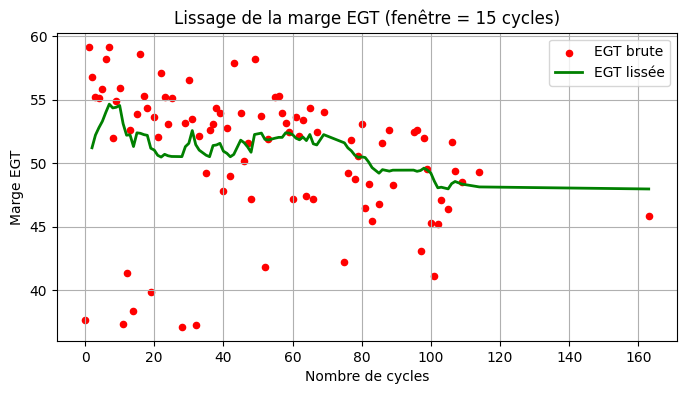

In [ ]:
# On applique le lissage par moyenne glissante
egt_lisse = egt.rolling(window=15, min_periods=3).mean()

# Affichage des courbes
plt.figure(figsize=(8, 4))
plt.scatter(egt.index, egt, color='red', label='EGT brute', s=20)
plt.plot(egt_lisse.index, egt_lisse, color='green', label='EGT lissée', linewidth=2)
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Lissage de la marge EGT (fenêtre = 15 cycles)')
plt.legend()
plt.grid(True)
plt.show()


#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

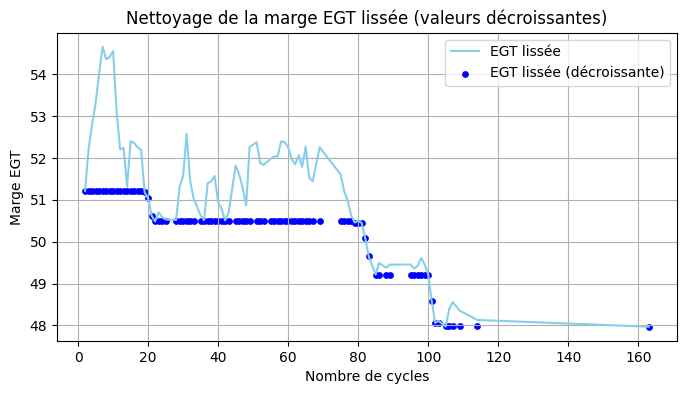

In [ ]:
# On calcule la version décroissante de la série lissée
egt_lisse_decroissante = egt_lisse.copy()
egt_lisse_decroissante = egt_lisse_decroissante.interpolate()  # remplace NaN pour éviter les coupures
egt_lisse_decroissante = egt_lisse_decroissante.cummin()       # impose la décroissance

# Visualisation sur le même graphique
plt.figure(figsize=(8, 4))
plt.plot(egt_lisse.index, egt_lisse, color='skyblue', label='EGT lissée')
plt.scatter(egt_lisse_decroissante.index, egt_lisse_decroissante,
            color='blue', s=15, label='EGT lissée (décroissante)')
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Nettoyage de la marge EGT lissée (valeurs décroissantes)')
plt.legend()
plt.grid(True)
plt.show()


#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [ ]:
from sklearn.linear_model import LinearRegression

Pente estimée : -0.023679
Ordonnée à l'origine : 51.505


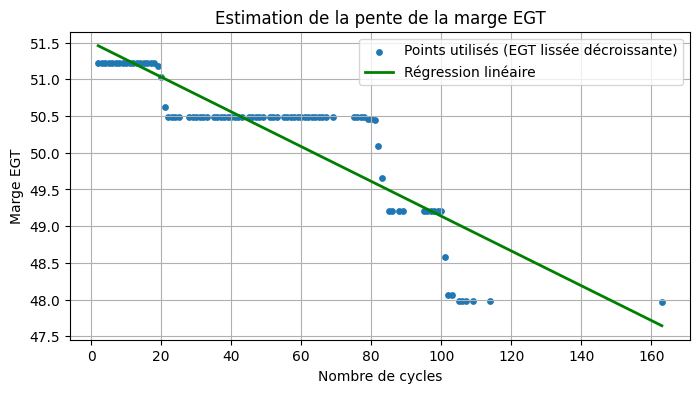

In [ ]:

import numpy as np


# On retire les valeurs manquantes de la série lissée décroissante
mask = np.isfinite(egt_lisse_decroissante)
X = np.array(egt_lisse_decroissante.index[mask]).reshape(-1, 1)
y = egt_lisse_decroissante[mask].values

# Création et entraînement du modèle de régression linéaire
lr = LinearRegression()
lr.fit(X, y)

# Récupération des coefficients
pente = lr.coef_[0]
intercept = lr.intercept_

print(f"Pente estimée : {pente:.6f}")
print(f"Ordonnée à l'origine : {intercept:.3f}")

# Tracé de la droite obtenue
plt.figure(figsize=(8, 4))
plt.scatter(X, y, s=15, label='Points utilisés (EGT lissée décroissante)')
plt.plot(X, lr.predict(X), color='green', linewidth=2, label='Régression linéaire')
plt.xlabel('Nombre de cycles')
plt.ylabel('Marge EGT')
plt.title('Estimation de la pente de la marge EGT')
plt.legend()
plt.grid(True)
plt.show()


### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

In [ ]:


def regress_egt_margin(df_acars):
    results = []

    # On parcourt chaque moteur individuellement
    for (engine_type, engine_number), group in df_acars.groupby(['engine_type', 'engine_number']):
        # Nettoyage des données : supprimer les NaN
        group = group.dropna(subset=['cycles', 'egthdm'])
        if group.empty:
            continue

        #Agrégation : garder la valeur maximale d'EGT par cycle
        egt = group.groupby('cycles')['egthdm'].max()

        # Réindexation sur la plage complète de cycles
        full_index = np.arange(int(egt.index.min()), int(egt.index.max()) + 1)
        egt = egt.reindex(full_index)

        # Lissage + forçage décroissant
        egt_smooth = egt.rolling(window=15, min_periods=3).mean()
        egt_smooth = egt_smooth.interpolate().cummin()

        # Régression linéaire
        mask = np.isfinite(egt_smooth)
        X = full_index[mask].reshape(-1, 1)
        y = egt_smooth[mask].values

        if len(y) < 5:
            continue  # pas assez de points pour une régression fiable

        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_

        # Stocker le résultat
        results.append({
            'engine_type': engine_type,
            'engine_number': engine_number,
            'slope': slope,
            'intercept': intercept
        })

    # Conversion en DataFrame
    df_regress_models = pd.DataFrame(results)
    return df_regress_models

# Application de la fonction
df_regress_models = regress_egt_margin(df)
print(df_regress_models.head())


   engine_type  engine_number     slope   intercept
0            5              1 -0.112603   91.916080
1            5              2 -0.167901  107.610988
2            5              3 -0.053902   96.426356
3            5              4 -0.042760   95.866475
4            5              5 -0.158692  110.353723


### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

<Figure size 800x400 with 0 Axes>

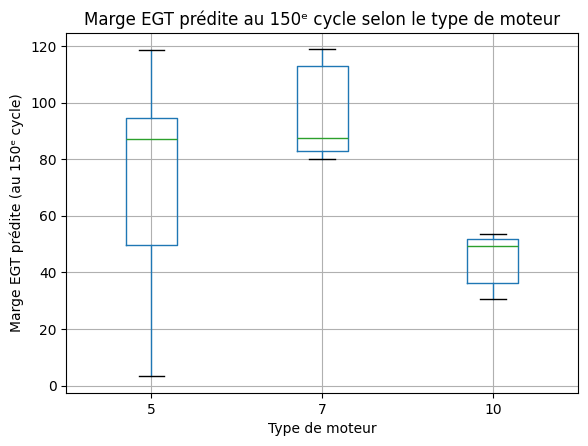

Marge EGT moyenne au 150ᵉ cycle par type de moteur :
engine_type
7     96.180461
5     75.439485
10    44.614006
Name: pred_150, dtype: float64

 Le type de moteur ayant la plus grande marge moyenne après 150 cycles est : 7


In [ ]:


# Calcul de la marge EGT prédite au 150ᵉ cycle pour chaque moteur
#     y = intercept + slope * 150
df_regress_models['pred_150'] = df_regress_models.apply(
    lambda row: row['intercept'] + 150 * row['slope'], axis=1
)

# Représentation graphique : boxplot par type de moteur
plt.figure(figsize=(8,4))
df_regress_models.boxplot(column='pred_150', by='engine_type', grid=False)
plt.title("Marge EGT prédite au 150ᵉ cycle selon le type de moteur")
plt.suptitle("")  # retire le titre automatique de pandas
plt.xlabel("Type de moteur")
plt.ylabel("Marge EGT prédite (au 150ᵉ cycle)")
plt.grid(True)
plt.show()

#Moyenne par type de moteur
moyennes_150 = df_regress_models.groupby('engine_type')['pred_150'].mean().sort_values(ascending=False)
print("Marge EGT moyenne au 150ᵉ cycle par type de moteur :")
print(moyennes_150)

# Type de moteur avec la plus grande marge moyenne
meilleur_type = moyennes_150.index[0]
print(f"\n Le type de moteur ayant la plus grande marge moyenne après 150 cycles est : {meilleur_type}")


#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?

Unité de la pente : marge EGT / cycle


<Figure size 800x400 with 0 Axes>

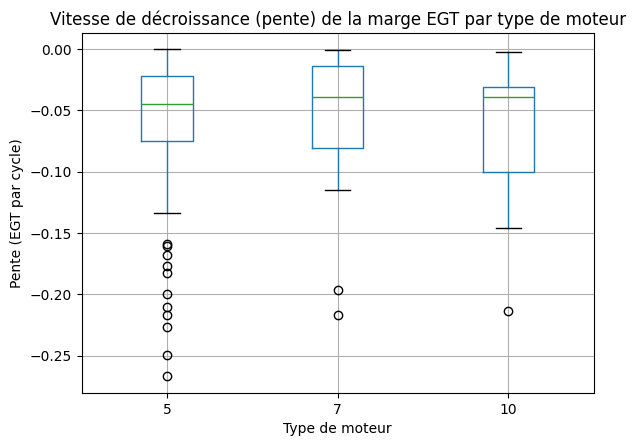

Pente moyenne par type de moteur :
engine_type
10   -0.068591
7    -0.058275
5    -0.055993
Name: slope, dtype: float64

 Le type de moteur ayant la plus faible vitesse d'usure est : 5


In [ ]:
# Unité de la pente
print("Unité de la pente : marge EGT / cycle")

#  Boxplot de la pente par type de moteur
plt.figure(figsize=(8,4))
df_regress_models.boxplot(column='slope', by='engine_type', grid=False)
plt.title("Vitesse de décroissance (pente) de la marge EGT par type de moteur")
plt.suptitle("")  # supprime le titre automatique
plt.xlabel("Type de moteur")
plt.ylabel("Pente (EGT par cycle)")
plt.grid(True)
plt.show()

# Moyenne de la pente par type de moteur
moyennes_pente = df_regress_models.groupby('engine_type')['slope'].mean().sort_values()
print("Pente moyenne par type de moteur :")
print(moyennes_pente)

# Détermination du moteur le plus résistant (pente la plus proche de 0)
meilleur_type = moyennes_pente.index[-1]
print(f"\n Le type de moteur ayant la plus faible vitesse d'usure est : {meilleur_type}")
